In [1]:
import importlib
import os
import math
import time
from collections import OrderedDict
import numpy as np
import pandas as pd
import datetime
import datetime as dt
from datetime import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from scipy.stats import pearsonr, spearmanr
import copy
import bert
import random
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from scipy import signal
import scipy.fftpack
import pmdarima as pm
from collections import deque
import pmdarima
from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import lag_plot
from pylab import rcParams
import plotly.express as px
import plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

from sklearn.metrics import r2_score, mean_absolute_error
from fbprophet import Prophet

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# import function
import src
import src.analysis
importlib.reload(src.analysis)
from src.analysis import Analysis

from src.Config import Config

In [3]:
def seasonal_decompose(df, col):
    sub_df = df[[col]]
    decomposition = seasonal.seasonal_decompose(sub_df)

    trend = decomposition.trend
    cycle = decomposition.seasonal
    residual = decomposition.resid
    
    return trend, cycle, residual

In [4]:
def component_plot(df, col):
    trend, cycle, residual = seasonal_decompose(df, col)

    fig, axarr = plt.subplots(4, figsize=(20,10), sharex=True)

    df[col].plot(ax=axarr[0], color='b', linestyle='-')
    axarr[0].set_title('Daily Search from All Access')

    trend.plot(color='r', linestyle='-', ax=axarr[1])
    axarr[1].set_title('Trend Component')

    cycle.plot(color='g', linestyle='-', ax=axarr[2])
    axarr[2].set_title('Seasonal Component')

    residual.plot(color='k', linestyle='-', ax=axarr[3])
    axarr[3].set_title('Irregular Variations')
    
    return

# Load Data

In [5]:
analysis = Analysis()

Loading BIODIESEL B10 data ...
  Generate time series features ...
    Understand the mean and standard deviation of time series data for better understanding on the data ...
    Moving average on 7 and 21 period size ...
    Moving average convergence divergence ...
    Bollinger band ...
    Rate of change ...
    Exponential moving average ...
    Momentum ...
  Extract time series feature in frequency domain ...
  Create ARIMA as one of the features for supervised learning model ...
  Prepare time series feature to the right format ...
  Saving  Biodiesel dataframe to file 'data_local\biodiesel_B10.csv' ...
  done.


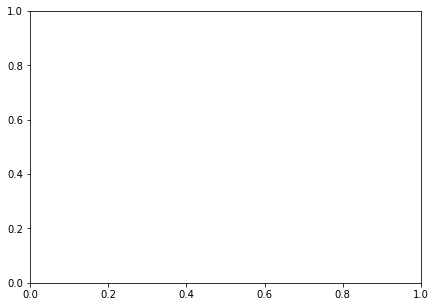

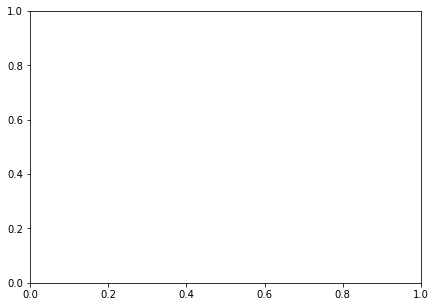

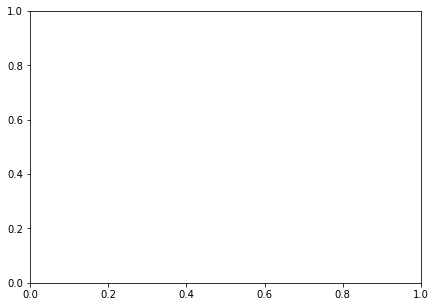

In [6]:
analysis.get_biodiesel()

In [7]:
temp_df = analysis.data['biodiesel_df'].loc[(analysis.data['biodiesel_df']['District']=='Sitiawan')]
temp_df = temp_df.drop(['Unnamed: 0'], axis=1)
temp_df.index = pd.to_datetime(temp_df.index)

In [8]:
temp_df = temp_df.reset_index()

fig = px.line(temp_df, x='Date', y='Prod_Sales', title='Biodiesel 50 - Sititawan')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

# temp_df = temp_df.set_index('Date')

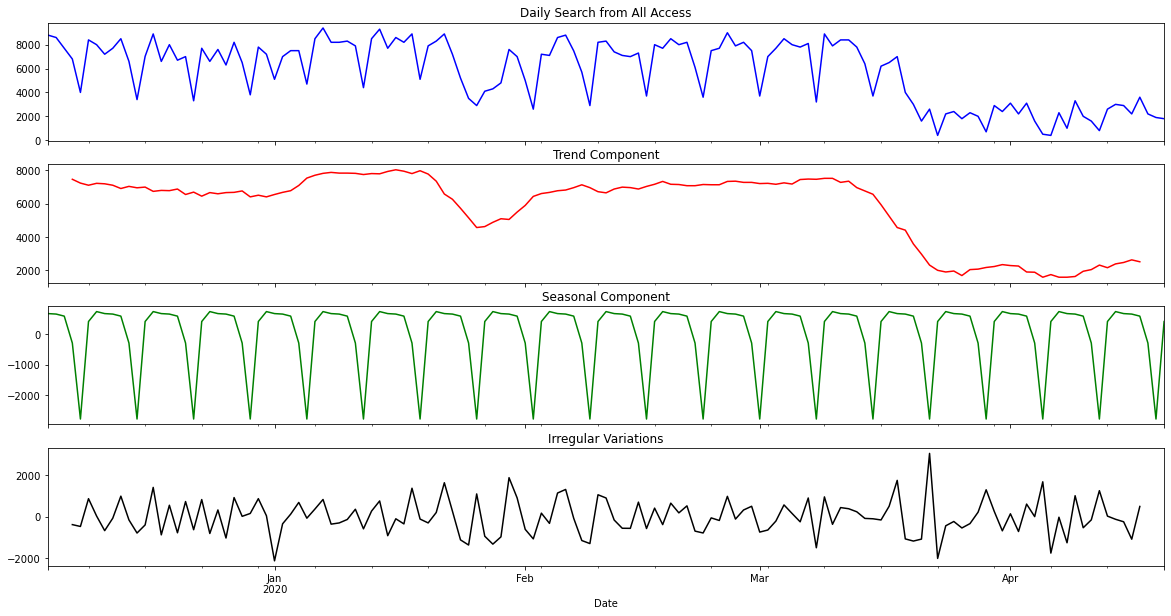

In [9]:
temp_df = temp_df.set_index('Date')

component_plot(temp_df, 'Prod_Sales')

In [10]:
sub_temp_df = temp_df[['Prod_Sales']]
week_sub_temp_df = sub_temp_df.resample('W', label='left', loffset=pd.DateOffset(days=1)).mean()

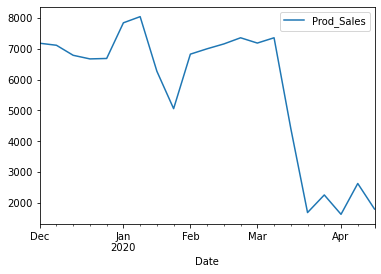

In [11]:
%matplotlib inline

week_sub_temp_df.plot()

# Testing on ARIMA Model

In [12]:
def difference(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        days_difference = 7
        diff = difference(history, days_difference)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, days_difference)
        predictions.append(yhat)
        history.append(test[t])

    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(data, p_values, d_values, q_values):
    data = data.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(data, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [13]:
train_size = int(len(sub_temp_df) * 0.75)

sales_value = sub_temp_df.values
train, test = sales_value[0: train_size], sales_value[train_size: len(sales_value)]

In [14]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 7)

evaluate_models(sales_value, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=1647.376
ARIMA(0, 0, 2) RMSE=1549.538
ARIMA(0, 0, 3) RMSE=1585.010
ARIMA(0, 0, 4) RMSE=1482.177
ARIMA(0, 0, 5) RMSE=1497.252
ARIMA(0, 0, 6) RMSE=1378.612
ARIMA(0, 1, 1) RMSE=1456.873
ARIMA(0, 1, 2) RMSE=1449.844
ARIMA(0, 1, 3) RMSE=1632.990
ARIMA(0, 1, 4) RMSE=1402.856
ARIMA(0, 1, 5) RMSE=1534.885
ARIMA(0, 1, 6) RMSE=1541.194
ARIMA(1, 0, 0) RMSE=1521.016
ARIMA(1, 0, 1) RMSE=1434.650
ARIMA(1, 0, 2) RMSE=1536.272
ARIMA(1, 0, 4) RMSE=1310.731
ARIMA(1, 0, 5) RMSE=1483.576
ARIMA(1, 0, 6) RMSE=1266.735
ARIMA(1, 1, 0) RMSE=1436.889
ARIMA(1, 1, 1) RMSE=1515.567
ARIMA(1, 1, 2) RMSE=1395.741
ARIMA(1, 1, 3) RMSE=1512.032
ARIMA(1, 1, 4) RMSE=1442.238
ARIMA(2, 0, 0) RMSE=1393.333
ARIMA(2, 0, 1) RMSE=1365.786
ARIMA(2, 1, 0) RMSE=1443.462
ARIMA(2, 1, 1) RMSE=1419.859
ARIMA(2, 1, 3) RMSE=1458.220
ARIMA(2, 1, 4) RMSE=1487.754
Best ARIMA(1, 0, 6) RMSE=1266.735


In [15]:
days_difference = 7

history = [x for x in train]
predictions = list()

In [16]:
for i in range(len(test)):
    differenced = difference(history, days_difference)
    model = ARIMA(differenced, order=(1,0,6))
    model_fit = model.fit(trend='nc', disp=0)

    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, days_difference)
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

>Predicted=7897.651, Expected=6500
>Predicted=5819.362, Expected=7000
>Predicted=6676.368, Expected=4000
>Predicted=5600.390, Expected=3000
>Predicted=3054.245, Expected=1600
>Predicted=-873.211, Expected=2600
>Predicted=4608.458, Expected=400
>Predicted=3006.475, Expected=2200
>Predicted=2044.226, Expected=2400
>Predicted=3310.505, Expected=1800
>Predicted=355.882, Expected=2300
>Predicted=888.096, Expected=2000
>Predicted=-17.284, Expected=700
>Predicted=2829.276, Expected=2900
>Predicted=3283.501, Expected=2400
>Predicted=3587.318, Expected=3100
>Predicted=3263.401, Expected=2200
>Predicted=1480.548, Expected=3100
>Predicted=1711.900, Expected=1600
>Predicted=255.418, Expected=500
>Predicted=2356.896, Expected=400
>Predicted=2048.346, Expected=2300
>Predicted=2390.813, Expected=1000
>Predicted=1959.653, Expected=3300
>Predicted=867.715, Expected=2000
>Predicted=1776.319, Expected=1600
>Predicted=-502.289, Expected=800
>Predicted=2521.897, Expected=2600
>Predicted=3452.739, Expected=

NameError: name 'y' is not defined